# Identification of a Neural-Network for Constitutive Law

## Preliminary part - Introduction

To allow inline pictures, run the following block

In [1]:
%matplotlib inline

Import all the useful libraries before first run
We need here the classic ones such as:
- math
- numpy
- scipy
- pandas
- matplotlib

And for the Neural Network, we also need to import parts of the keras module of TensorFlow

In [2]:
import math
import numpy as np
#import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Importation de TensorFlow 
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers.core import Dense, Activation
from keras import optimizers

**Global definitions**

Here after, we define the colors to use for plotting.

In [3]:
saveFigures = False
colorlist = ['#bb0000', '#00bb00', "#0000bb", '#bbbb00', '#bb00bb', "#00bbbb", '#bbbbbb', '#770000', '#007700', "#000077", '#777700', '#770077', "#007777", '#777777']

Useful functions to define the number of subplots to use

In [4]:
baseSize = (8,6) # Base size of a subplot

def sbPlot(n):
    if (n == 1): return 1, 1
    if (n <= 2): return 1, 2
    if (n <= 4): return 2, 2
    if (n <= 6): return 3, 2
    if (n <= 9): return 3, 3
    if (n <=12): return 4, 3
    return 0,0

def sbPlotSize(n):
    x, y = sbPlot(n)
    return baseSize[0]*y, baseSize[1]*x

Used to plot an Histogram

In [5]:
def getDigitsFrom(n):
    d = int(math.log10(abs(n)))
    return n*10**(-d + 1)

def plotHisto(Y, labels, bottom, top, xlab, ylab, figname, title):
    numb = len(Y)
    X = np.arange(numb) +1

    plt.figure(figsize = (12, 9)) # for a4 landscape
    plt.rc('text', usetex=True)
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16

    plt.bar(X, Y, color = '#770000')

    for x, y in zip(X, Y):
        plt.text(x, y + 0.01*(top-bottom), '$%.2f$' % getDigitsFrom(y), ha='center', va='bottom', fontsize=16)

    for i in range(0,numb):
        if (Y[i]> 0.5*top):
            plt.text(X[i], (top-bottom)/10+bottom , labels[i], ha='center', va='bottom', fontsize=20, rotation=90, color='white')
        else:
            plt.text(X[i], 5*(top-bottom)/10+bottom , labels[i], ha='center', va='bottom', fontsize=20, rotation=90, color='black')

    plt.ylim(bottom, top)

    plt.ylabel(ylab, fontsize = 20)
    plt.xlabel(xlab, fontsize = 20)
    plt.title(title, fontsize = 20)

    plt.tick_params(axis='x',top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
    plt.grid(True)
    if (saveFigures) : plt.savefig(figname)
    plt.show()

## Definition of the data file to use 
We define here after the directory and the Excel Datafile used for the Neural-Network construction.

In [6]:
dataPath = 'ANN-JohnsonCook'
dataFile = 'JC-Experiments.xlsx'

## Open the Excel file and import data
Read the content of the Excel file using the pandas library method read_excel.

In this datafile, temperatures must be on separate sheets, while the corresponding sheets contains stress / strain / strain-rate values: $$\overline{\sigma}=f({\overline{\varepsilon}^p},\dot{\overline{\varepsilon}^p})$$

In [7]:
excelData = pd.read_excel(dataPath + '/' + dataFile, None)

Extract the list of temperatures $T$ from the the Excel file.

In [8]:
len(excelData)
temperatures = []
temps = list(excelData.keys())
for T in temps:
    temperatures.append(int(T.replace('°C','')))
temperaturesOrig = temperatures
nTemp = len(temperatures)
nTemp, temperatures

(6, [20, 100, 200, 300, 500, 800])

Extract the list of plastic strain rates $\dot{\overline{\varepsilon}^p}$ from the the Excel file.

In [9]:
dataSheet = excelData[str(temperatures[0]) + '°C']
epsp = []
for i in range(1, dataSheet.shape[1]):
    epsp.append(dataSheet.columns[i])
epspOrig = epsp
nEpsp = len(epsp)
nEpsp, epsp

(5, [0.1, 1, 50, 1000, 500000])

Extract all data from the panda sheets.

In [10]:
# Read first sheet
dataSheet = excelData[str(temperatures[0]) + '°C']
data = dataSheet.values
eps = data[:,0]
sig = data[:,1:]
# Append the other sheets
for T in temperatures[1:]:
    dataSheet = excelData[str(T) + '°C']
    data = dataSheet.values
    sig = np.append(sig, data[:,1:], axis=1)
nEps = len(eps)

Creates two arrays for temperatures $T$ and plastic strain rates $\dot{\overline{\varepsilon}^p}$ and transforms the values of the plastic strain rates $\dot{\overline{\varepsilon}^p}$ into its logarithmic part.

**It is very important** to transform the epsp data into its logarithmic part since entries of the ANN show enhance a linear behavior.

In [11]:
temperatures = np.array(temperatures)
epsp = np.array(epsp)
epsLogBase = epsp.min()
epsp = np.log(epsp/epsLogBase)
epspArray = np.tile(epsp,temperatures.shape[0])
temperaturesArray = temperatures.repeat(epsp.shape[0])
epspArray.shape, epspArray, temperaturesArray

((30,),
 array([ 0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847]),
 array([ 20,  20,  20,  20,  20, 100, 100, 100, 100, 100, 200, 200, 200,
        200, 200, 300, 300, 300, 300, 300, 500, 500, 500, 500, 500, 800,
        800, 800, 800, 800]))

Transform all data into an array of 4 columns where:
- $\overline{\varepsilon}^p$ : is in first column
- $\dot{\overline{\varepsilon}^p}$ : is in second column
- $T$ : is in third column
- $\overline{\sigma}$ : is th fourth column

In [12]:
entries = np.empty([epspArray.shape[0]*eps.shape[0], 4])
row = 0
colEps = 0
colEpsp = 1
colT = 2
colSig = 3
for i in range(epspArray.shape[0]):
    for j in range(eps.shape[0]):
        entries[row, colEps] = eps[j]
        entries[row, colEpsp] = epspArray[i]
        entries[row, colT] = temperaturesArray[i]
        entries[row, colSig] = sig[j,i]
        row += 1
entries.shape, entries

((1500, 4),
 array([[0.00000000e+00, 0.00000000e+00, 2.00000000e+01, 8.06000000e+02],
        [2.04081633e-02, 0.00000000e+00, 2.00000000e+01, 1.12531214e+03],
        [4.08163265e-02, 0.00000000e+00, 2.00000000e+01, 1.16474716e+03],
        ...,
        [9.59183673e-01, 1.54249485e+01, 8.00000000e+02, 8.37173720e+02],
        [9.79591837e-01, 1.54249485e+01, 8.00000000e+02, 8.38451238e+02],
        [1.00000000e+00, 1.54249485e+01, 8.00000000e+02, 8.39706802e+02]]))

Then, we must normalize all the entries, so that they vary within the range $[0:1]$.

- We compute the minEntries variable that contains all the min Values
- We shift all data by substracting the min value to all values
- Then we compute the maxEntries variable that contains all the max Values
- We normalize the data by dividing all variables by the maxEntries

To rebuid data, we must:
- Multiply the value by maxEntries
- Add the minEntries to the result

In [13]:
minEntries = entries.min(axis=0)
NNentries = entries - np.array(minEntries)
maxEntries = NNentries.max(axis=0)
NNentries = NNentries / np.array(maxEntries)
minEntries, maxEntries, NNentries

(array([  0.        ,   0.        ,  20.        , 419.08892784]),
 array([1.00000000e+00, 1.54249485e+01, 7.80000000e+02, 1.19585157e+03]),
 array([[0.        , 0.        , 0.        , 0.32354439],
        [0.02040816, 0.        , 0.        , 0.59056093],
        [0.04081633, 0.        , 0.        , 0.62353744],
        ...,
        [0.95918367, 1.        , 1.        , 0.34961261],
        [0.97959184, 1.        , 1.        , 0.3506809 ],
        [1.        , 1.        , 1.        , 0.35173084]]))

To check the previous process precision, and lost of data

In [14]:
print("Max error for normalized data is :",(NNentries * maxEntries + minEntries - entries).max())

Max error for normalized data is : 2.2737367544323206e-13


## Plot the original data

Plots the original data where subplots are dependents on the temperature $T$

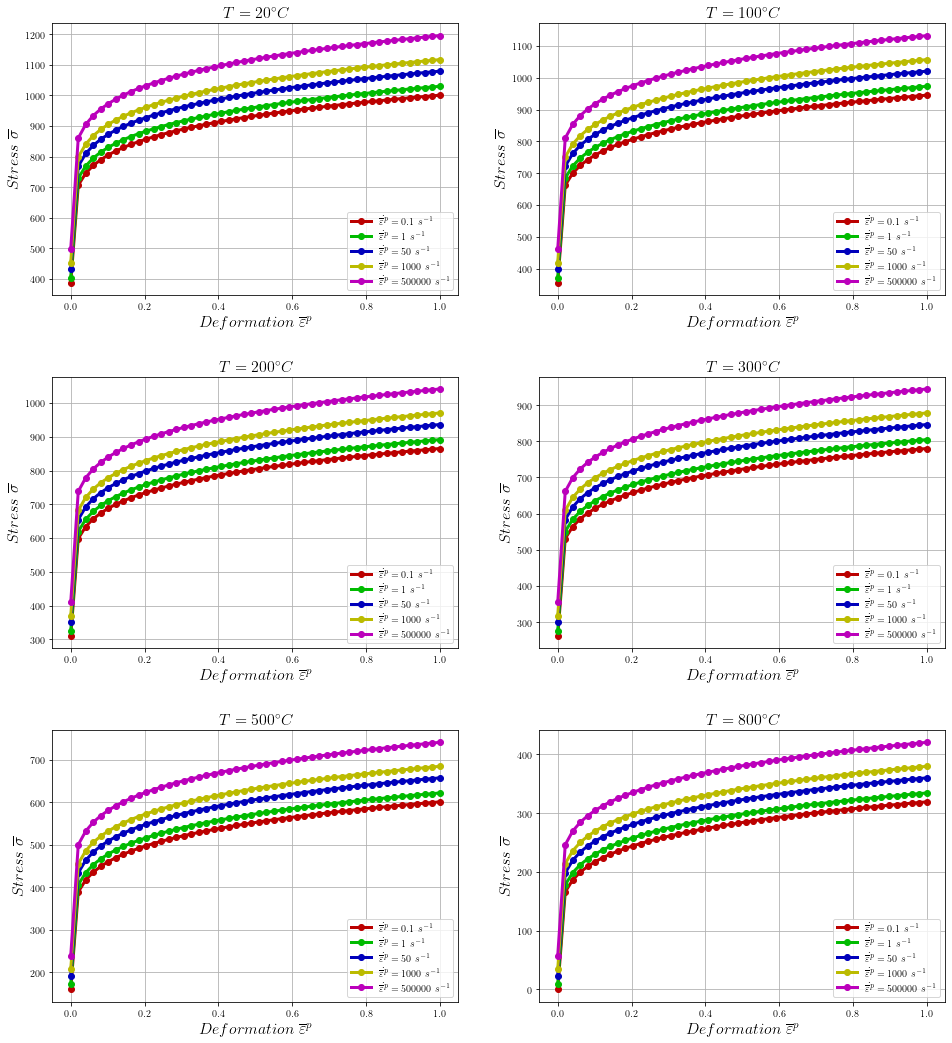

In [15]:
plt.figure(figsize = sbPlotSize(nTemp))
plt.rc('text', usetex = True)
plt.subplots_adjust(hspace = 0.3)
idx = 1
for T in temperatures:
    xs, ys = sbPlot(nTemp)
    plt.subplot(xs, ys, idx)
    cl = 0
    for epspv, epspvv in zip(epsp, epspOrig):
        # filter on T
        data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
        # Plot the curves
        plt.plot(data[:,colEps]*maxEntries[colEps]+minEntries[colEps], data[:,colSig]*maxEntries[colSig]+minEntries[colEps], color=colorlist[cl], label=r'$\dot{\overline{\varepsilon}^p}=' + str(epspvv) + '\ s^{-1}$', marker='o', linewidth = 3)
        cl += 1
    plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 10)
    plt.grid()
    plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
    plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16)
    plt.title(r'$T=' + str(T) + '^{\circ}C$', fontsize = 16)
    idx += 1
if (saveFigures) : plt.savefig(dataPath + '/' + 'OriginalData-T.svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

Plots the original data where subplots are dependents on the plastic strain rate $\dot{\overline{\varepsilon}^p}$

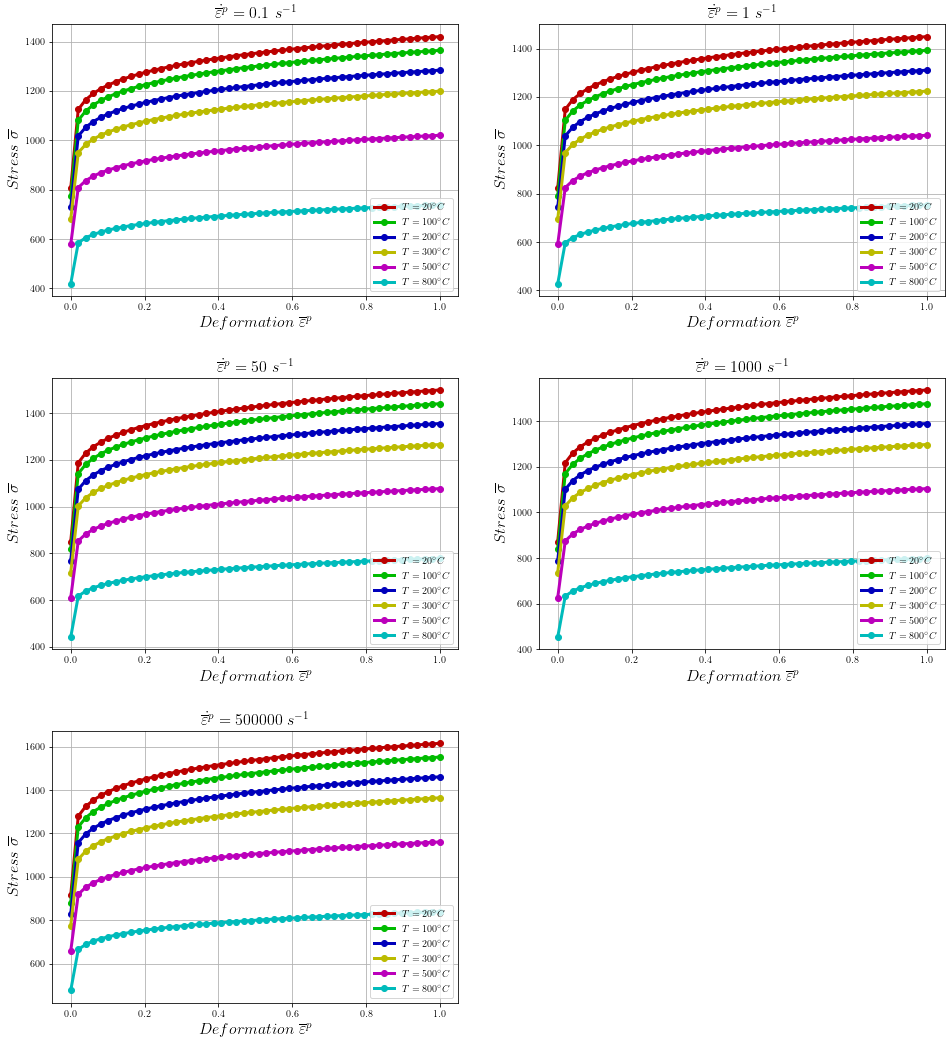

In [16]:
plt.figure(figsize = sbPlotSize(nEpsp))
plt.rc('text', usetex = True)
plt.subplots_adjust(hspace = 0.3)
idx = 1
for epspv, epspvv in zip(epsp, epspOrig):
    xs, ys = sbPlot(nEpsp)
    plt.subplot(xs, ys, idx)
    cl = 0
    for T, TOrig in zip(temperatures, temperaturesOrig):
        # filter on T
        data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
        # Plot the curves
        plt.plot(data[:,colEps]*maxEntries[colEps]+minEntries[colEps], data[:,colSig]*maxEntries[colSig]+minEntries[colSig], color=colorlist[cl], label=r'$T=' + str(TOrig) + '^{\circ}C$', marker = 'o', linewidth = 3)
        cl += 1
    plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 10)
    plt.grid()
    plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
    plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16)
    plt.title(r'$\dot{\overline{\varepsilon}^p}=' + str(epspvv) + '\ s^{-1}$', fontsize = 16)
    idx += 1
if (saveFigures) : plt.savefig(dataPath + '/' + 'OriginalData-epsp.svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Data form transformation for the ANN

Separate input and output from data.

Input contains:
- $\overline{\varepsilon}^p$ : is in first column
- $\dot{\overline{\varepsilon}^p}$ : is in second column
- $T$ : is in third column

Output contains:
- $\overline{\sigma}$ : the only column

In [17]:
NNinput = NNentries[:,colEps:colSig]
NNoutput = NNentries[:,colSig]
NNinput.shape, NNoutput.shape

((1500, 3), (1500,))

## Neural Network set-up

In [18]:
models = []              # The list of models to use
convergenceCurves = []   # To store convergence curves

#FACT = ['relu', 'sigmoid', 'tanh']
#COUCH = [3, 5, 7, 9]
FACT = ['relu', 'sigmoid', 'tanh']
COUCH = [5, 7, 9]
#COUCH = [[5,2], [5,3], [5,4]]

FACT = ['tanh']
COUCH = [5]

for f in FACT:
    for c in COUCH:
        desc = '3'
        model = Sequential()
        if type(c) == list:
            fst = True
            for k in c:
                if (fst): model.add(Dense(k, input_dim = 3, activation = f))
                else: model.add(Dense(k, activation = f))
                fst = False
                desc += '-' + str(k)
        else:
            model.add(Dense(c, input_dim = 3, activation = f))
            desc += '-' + str(c)
        model.add(Dense(1))
        desc += '-1-'+f
        model._name = desc
        models.append(model)

Initialize models and apply solver and optimizer for each one.

Here, we choose the **adam** solver and a **mse** error.

In [19]:
for model in models:
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])
    model.summary()

Model: "3-5-1-tanh"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


## Solve the parameters of all ANN models

In [20]:
iterationsNumber = 20 # Define the number of iteration to do
epochNumber = 1000    # Define the number of epoch for each iteration

for model in models:
    hist = np.array([])
    print("MODEL :", model.name)
    for i in range(iterationsNumber):
        history = model.fit(NNinput, NNoutput, epochs = epochNumber, verbose = 0)
        loss = history.history['loss']
        hist = np.append(hist, loss)
        print("Iteration :", i+1, "/", iterationsNumber, '-> %8.6E' % loss[-1], "  ", end = '\r')
    print("\n")
    convergenceCurves.append(hist)

MODEL : 3-5-1-tanh
Iteration : 20 / 20 -> 3.876345E-06   



## Plot results of the optimization procedure

First, we plot the convergence curves

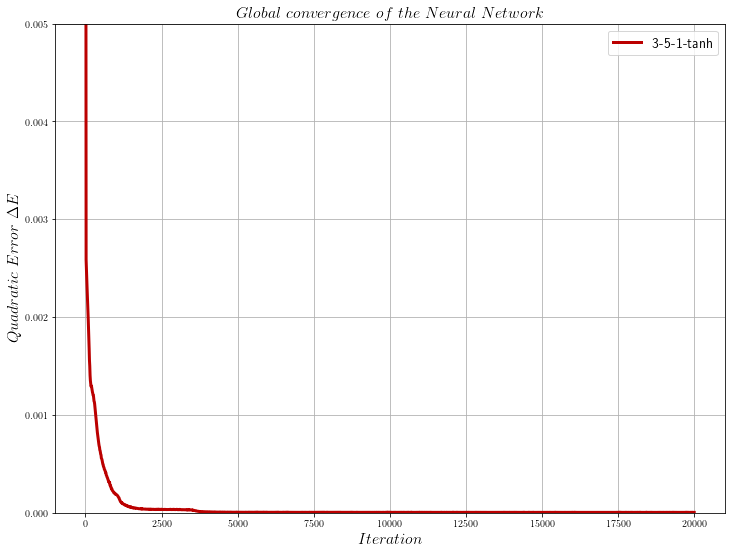

In [21]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
cl = 0
for model, curve in zip(models, convergenceCurves):
    shortCurve = curve[::10]
    x = np.linspace(0, len(curve), len(shortCurve))
    plt.plot(x, shortCurve, label = model.name, color=colorlist[cl], linewidth = 3)
    cl += 1
plt.grid()
plt.xlabel(r'$Iteration$', fontsize = 16)
plt.ylim(0, 5e-3)
plt.ylabel(r'$Quadratic\ Error\ \Delta E$', fontsize = 16)
plt.title(r'$Global\ convergence\ of\ the\ Neural\ Network$', fontsize = 16)
plt.legend(loc = 'upper right',fancybox = True, numpoints = 1, fontsize = 14)
if (saveFigures) : plt.savefig(dataPath + '/' + 'Convergence.svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

The we plot the history of all models precision

In [ ]:
plt.figure(figsize = (12, 9))
plt.rc('text', usetex = True)
convs = np.array([])
labels = []
for model, curve in zip(models, convergenceCurves):
    lastzone = int(len(curve)/20) # 5% des points pris en compte pour la convergence globale
    convs = np.append(convs, curve[-lastzone:].mean())
    labels.append(model.name)
bottom = 0
top = convs.max()*1.1
ylab = r'$Quadratic\ Error\ \Delta E$'
xlab = r'$Model\ used$'
figname = dataPath + '/' + 'Precision.svg'
title = r'$Global\ precision\ of\ the\ Neural\ Network$'
plotHisto(convs, labels, bottom, top, xlab, ylab, figname, title)

Plots the results of the model where all subplots are dependents on the plastic strain rate $\dot{\overline{\varepsilon}^p}$

In [ ]:
for model in models:
    predictedOutput = model.predict(NNinput)
    plotPredicted = predictedOutput.reshape(nEpsp*nTemp, nEps).T
    pcol = 0
    plt.figure(figsize = sbPlotSize(nTemp))
    plt.rc('text', usetex = True)
    plt.subplots_adjust(hspace = 0.3)
    idx = 1
    for T, TOrig in zip(temperatures, temperaturesOrig):
        pli = 0
        xs, ys = sbPlot(nTemp)
        plt.subplot(xs, ys, idx)
        for epspv, epspvAff in zip(epsp, epspOrig):
            # filter on T
            data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
            # Plot the curves
            plt.plot(data[:,colEps]*maxEntries[colEps]+minEntries[colEps], data[:,colSig]*maxEntries[colSig]+minEntries[colSig], color=colorlist[pli], label=r'$\dot{\overline{\varepsilon}^p}=' + str(epspvAff) + '\ s^{-1}$', marker = 'o', linestyle='none')
            plt.plot(data[:,colEps]*maxEntries[colEps]+minEntries[colEps], plotPredicted[:,pcol*nEpsp+pli]*maxEntries[colSig]+minEntries[colSig], colorlist[pli], linewidth = 3)
            pli += 1
        pcol += 1
        plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
        plt.grid()
        plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
        plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16)
        plt.title(r'$T=' + str(TOrig) + '^{\circ}C$', fontsize = 16)
        idx += 1
    if (saveFigures) : plt.savefig(dataPath + '/' + 'NN-' + model.name + '-epsp.svg', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

Plots the results of the model where all subplots are dependents on the temperature $T$

In [ ]:
for model in models:
    predictedOutput = model.predict(NNinput)
    plotPredicted = predictedOutput.reshape(nEpsp*nTemp, nEps).T
    pcol = 0
    plt.figure(figsize = sbPlotSize(nEpsp))
    plt.rc('text', usetex = True)
    plt.subplots_adjust(hspace = 0.3)
    idx = 1
    for epspv, epspvAff in zip(epsp, epspOrig):
        pli = 0
        xs, ys = sbPlot(nEpsp)
        plt.subplot(xs, ys, idx)
        for T, TOrig in zip(temperatures, temperaturesOrig):
            # filter on T
            data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
            # Plot the curves
            plt.plot(data[:,colEps]*maxEntries[colEps]+minEntries[colEps], data[:,colSig]*maxEntries[colSig]+minEntries[colSig], color=colorlist[pli], label=r'$T=' + str(TOrig) + '^{\circ}C$', marker = 'o', linestyle='none')
            plt.plot(data[:,colEps]*maxEntries[colEps]+minEntries[colEps], plotPredicted[:,pcol+nEpsp*pli]*maxEntries[colSig]+minEntries[colSig], colorlist[pli], linewidth = 3)
            pli += 1
        pcol += 1
        plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
        plt.grid()
        plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16)
        plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16)
        plt.title(r'$\dot{\overline{\varepsilon}^p}=' + str(epspvAff) + '\ s^{-1}$', fontsize = 16)
        idx += 1
    if (saveFigures) : plt.savefig(dataPath + '/' + 'NN-' + model.name + '-T.svg', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Save results for future use

Save the Tensorflow model

In [ ]:
for model in models:
    model.save(dataPath + '/' + model.name)

Save all internal arrays for direct use of the NN

In [22]:
for model in models:
    if len(model.layers)==1: 
        np.savez(dataPath + '/' + model.name,
                 logBase = np.array([epsLogBase]),
                 minEntries=minEntries, 
                 maxEntries=maxEntries,
                 w1=model.layers[0].get_weights()[0].T, 
                 b1=model.layers[0].get_weights()[1].reshape(len(model.layers[0].get_weights()[1]),1))
    if len(model.layers)==2: 
        np.savez(dataPath + '/' + model.name, 
                 logBase = np.array([epsLogBase]),
                 minEntries=minEntries, 
                 maxEntries=maxEntries,
                 w1=model.layers[0].get_weights()[0].T, 
                 b1=model.layers[0].get_weights()[1].reshape(len(model.layers[0].get_weights()[1]),1),
                 w2=model.layers[1].get_weights()[0].T, 
                 b2=model.layers[1].get_weights()[1].reshape(len(model.layers[1].get_weights()[1]),1))
    if len(model.layers)==3: 
        np.savez(dataPath + '/' + model.name, 
                 logBase = np.array([epsLogBase]),
                 minEntries=minEntries, 
                 maxEntries=maxEntries,
                 w1=model.layers[0].get_weights()[0].T, 
                 b1=model.layers[0].get_weights()[1].reshape(len(model.layers[0].get_weights()[1]),1),
                 w2=model.layers[1].get_weights()[0].T, 
                 b2=model.layers[1].get_weights()[1].reshape(len(model.layers[1].get_weights()[1]),1),
                 w3=model.layers[2].get_weights()[0].T, 
                 b3=model.layers[2].get_weights()[1].reshape(len(model.layers[2].get_weights()[1]),1)) 
    if len(model.layers)==4: 
        np.savez(dataPath + '/' + model.name, 
                 logBase = np.array([epsLogBase]),
                 minEntries=minEntries, 
                 maxEntries=maxEntries,
                 w1=model.layers[0].get_weights()[0].T, 
                 b1=model.layers[0].get_weights()[1].reshape(len(model.layers[0].get_weights()[1]),1),
                 w2=model.layers[1].get_weights()[0].T, 
                 b2=model.layers[1].get_weights()[1].reshape(len(model.layers[1].get_weights()[1]),1),
                 w3=model.layers[2].get_weights()[0].T, 
                 b3=model.layers[2].get_weights()[1].reshape(len(model.layers[2].get_weights()[1]),1),
                 w4=model.layers[3].get_weights()[0].T, 
                 b4=model.layers[3].get_weights()[1].reshape(len(model.layers[3].get_weights()[1]),1))             

## Test  efficiency of the NN with random values

Scan the content of the testDatabase if it exists

In [86]:
testFileName = dataPath + '/Datatest.npz'
import os.path
if (os.path.exists(testFileName)):
    
    # Load the test Database
    testDatabase = np.load(testFileName)
    testData = testDatabase['testData']
    
    # Number of rows of the test database
    nrows = testData.shape[0]
    
    # Extract data from the database
    eps_test = testData[:,0].reshape(nrows,1)
    epsp_test = testData[:,1].reshape(nrows,1)
    T_test = testData[:,2].reshape(nrows,1)
    sig_test = testData[:,3].reshape(nrows,1)
    
    # Computes the log of epsp
    epsp_test = np.log(epsp_test/epsLogBase)
    
    # Creates the input test data with scale
    inputTest = (np.hstack([eps_test, epsp_test, T_test]) - np.array(minEntries)[0:3]) / np.array(maxEntries)[0:3]
    
    # Computes the predicted values and rescale back them
    sigNN = model.predict(inputTest) * maxEntries[3] + minEntries[3]
    
    # Computes the error
    error = np.abs(sigNN - sig_test)/sigNN
    print("Mean error is:", np.mean(error))
    errorSort = np.sort(error, axis=0)
    largeErrors = errorSort[errorSort > np.mean(error)]
    print(len(largeErrors),'/',len(error),'points have large errors\n')
    
    # Display info for large errors
    for err in largeErrors[::-1]:
        loc = np.where(error == err)[0][0]
        print('err=%5.2f %% for' %(error[loc][0]*100), 'eps=', eps_test[loc][0], 'epsp=', math.exp(epsp_test[loc][0]), 'T=', T_test[loc][0])

Mean error is: 0.0027318490204239444
198 / 1000 points have large errors

err=18.44 % for eps= 0.001894163720070563 epsp= 2335916.3168917503 T= 42.53749052752639
err=18.08 % for eps= 0.0012419372836818265 epsp= 4802111.240995718 T= 184.36072874608317
err=16.69 % for eps= 0.0003096841744771872 epsp= 4433509.794075613 T= 435.30214583547047
err=12.47 % for eps= 0.004250670756169694 epsp= 2972906.869819309 T= 531.8240502975018
err= 9.58 % for eps= 0.005866649908411459 epsp= 3203024.631410378 T= 326.049075006221
err= 7.14 % for eps= 0.008238088092985207 epsp= 3154251.151806292 T= 135.01421257006558
err= 6.01 % for eps= 0.008650797103796348 epsp= 3170193.1518014134 T= 447.5259620623223
err= 5.22 % for eps= 0.010106654370244272 epsp= 1209743.899262143 T= 116.56074317269551
err= 5.07 % for eps= 0.009687744280776234 epsp= 2633258.382656215 T= 504.6134017601947
err= 3.48 % for eps= 0.012083744616879999 epsp= 4939732.54311561 T= 151.77650756127903
err= 1.88 % for eps= 0.015789800857476943 epsp= 7